# NMR

In [1]:
%matplotlib inline
import pymc as pm
import matplotlib.pyplot as plt
import scipy.stats as st
import arviz as az
import metropolis_commands as mc
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
plt.rcParams['figure.figsize'] = [5, 3]

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Die magnetische Kernresonanz (NMR: nuclear magnetic resonance) ist eine leistungsstarke Technik, die zur Untersuchung von Molekülen und auch von Lebewesen wie Menschen oder Hefe verwendet wird. 

Mit NMR kann man verschiedene Arten von beobachtbaren Grössen messen, die mit unbeobachtbaren und interessanten molekularen Eigenschaften zusammenhängen. Eine dieser beobachtbaren Grössen ist bekannt als chemische Verschiebung (Signalverschiebung gegenüber einem Referenzwert). Wir können chemische Verschiebungen allerdings nur für die Kerne bestimmter Atome erhalten.

All dies fällt in den Bereich der Quantenchemie; die Details sind für diese Diskussion irrelevant. Wir betrachten im Folgenden den Datensatz in der Datei `chemical_shifts.csv`. Darin enthalten sind 48 Werte für chemische Verschiebungen, die wir in ein `numpy`-Array laden und  mit Hilfe des folgenden Codes darstellen können:


In [2]:
df = pd.read_csv("./Daten/chemical_shifts.csv",header=None)
df.head()

,0
0,51.06
1,55.12
2,53.73
3,50.24
4,52.05


Die Daten müssen hinsichtlich der Modellierung nicht strikt normalverteilt sein, allerdings sollte die Normalverteilung eine vernünftige Annäherung an unsere Daten darstellen.

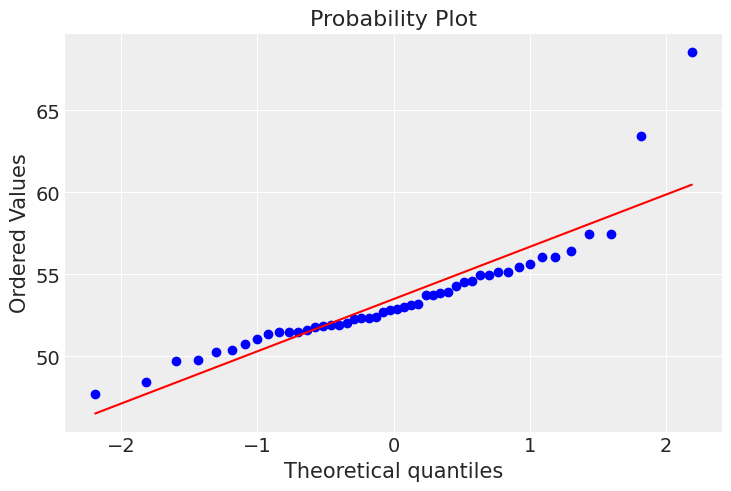

In [3]:
az.style.use("arviz-darkgrid")
st.probplot(df.iloc[:,0], plot=plt);

Die KDE-Darstellung (glatte Annäherung an ein Histogramm) dieses Datensatzes zeigt eine Gauss-ähnliche Verteilung, mit Ausnahme von zwei Datenpunkten, die weit vom Mittelwert entfernt sind.

([<matplotlib.axis.YTick at 0x7ff514916b30>], [Text(0, 0, '0')])

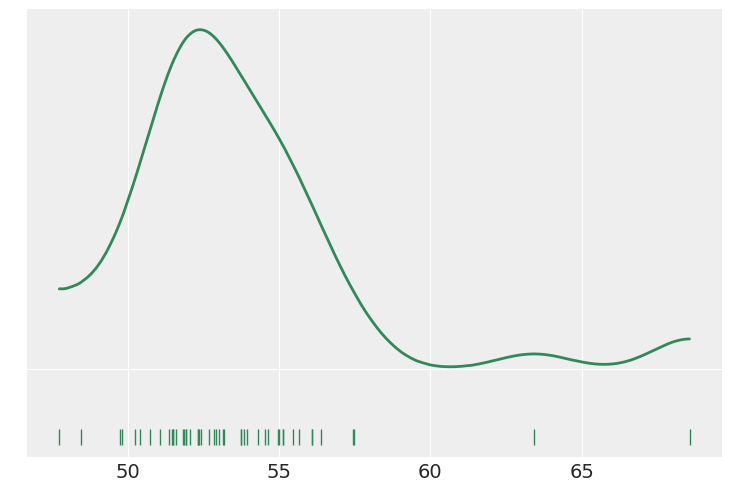

In [4]:
az.plot_kde(df.values, rug=True, rug_kwargs={"color" : "seagreen"}, plot_kwargs={"linewidth" : 2, "color" : "seagreen"})
plt.yticks([0], alpha=0)

Vergessen wir diese beiden Ausreisser für einen Moment und nehmen an, dass eine Gauss'sche Verteilung eine angemessene Beschreibung der Daten ist. Da wir weder den Mittelwert noch die Standardabweichung kennen, müssen wir eine Prior-Verteilungen für beide definieren. 

Ein vernünftiges Modell könnte daher lauten:
\begin{align*}
\mu &\sim \text{Uniform}(t_{\mu},h_{\mu})\\
\sigma &\sim \text{Uniform}(t_{\sigma},h_{\sigma})\\
y&\sim\mathcal{N}(\mu,\sigma^{2})
\end{align*}
Der Erwartungswert $ \mu $ stammt somit aus einer Gleichverteilung, wie $ \sigma $ auch. Im letzteren Fall müssen wir allerdings aufpassen, dass $ \sigma $ nicht negativ wird. 

Wenn wir die möglichen Werte von $ \mu $  und $ \sigma $ nicht kennen, können wir deren Prior-Verteilungen so definieren, dass darin unser Vorwissen, respektive unsere Unkenntnis widerspiegelt wird. Eine Möglichkeit besteht darin, als Prior-Verteilung eine Gleichverteilung mit Intervallgrenzen $ t_{\mu}=40 $ und $h_{\mu}=70 $ zu wählen, so dass der Bereich der Daten grösser ist. Alternativ können wir auch einen Bereich wählen, der auf unserem Vorwissen beruht. Wissen wir zum Beispiel, dass es physikalisch nicht möglich ist, Werte unter 0 oder über 100 für diese Art von Messung zu erhalten, so können wir die Prior-Verteilung für den Mittelwert als uniforme Verteilung mit den Parametern $ t_{\mu}=0 $ und  $h_{\mu}=100 $ wählen. Aus ähnlichen UeUberlegungen wählen wir die Prior-Verteilung für $ \sigma $ im Bereich von $ t_{\sigma}=0 $ bis  $h_{\sigma}=20 $.

\begin{align*}
\mu &\sim \text{Uniform}(40,70)\\
\sigma &\sim \text{Uniform}(0,20)\\
y&\sim\mathcal{N}(\mu,\sigma^{2})
\end{align*}

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


array([<Axes: title={'center': 'μ'}>, <Axes: title={'center': 'σ'}>],
      dtype=object)

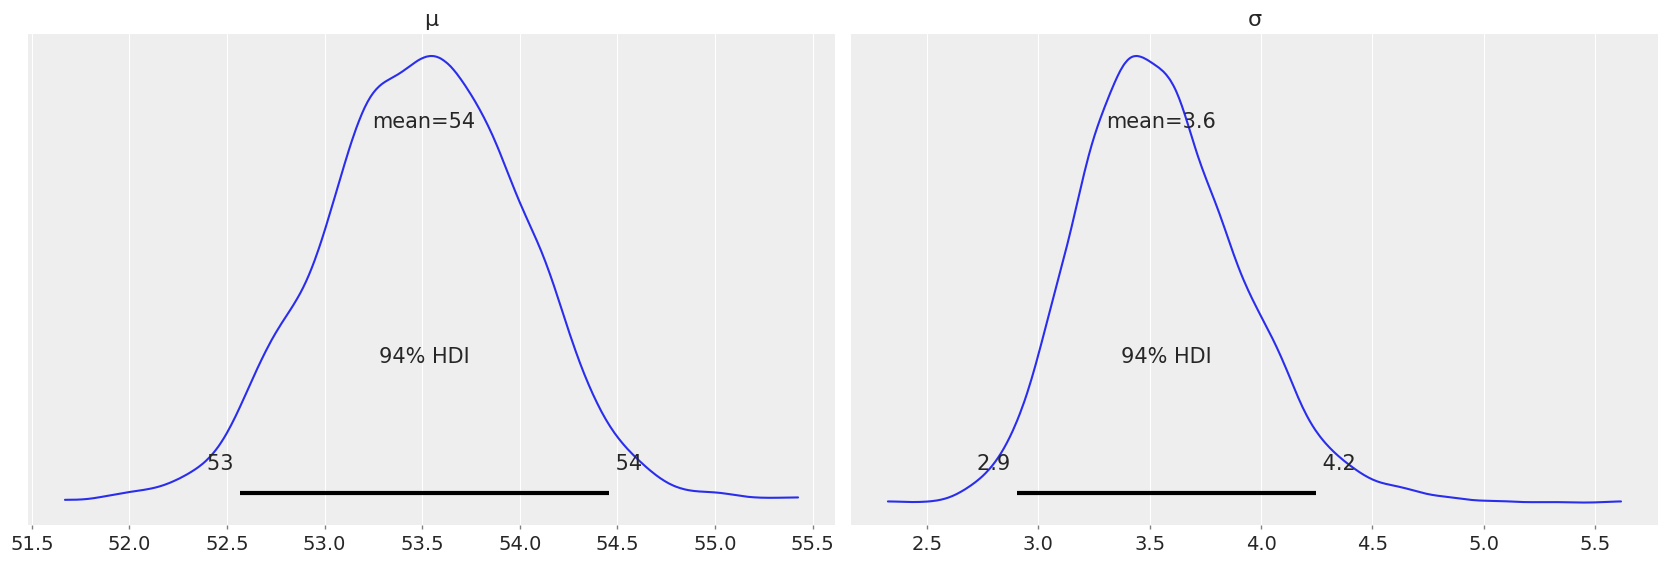

In [5]:
az.style.use("arviz-darkgrid")
with pm.Model() as model_g:
    μ = pm.Uniform('μ', lower=40, upper=70)
    σ = pm.Uniform('σ', lower=0, upper=20)
    y = pm.Normal('y', mu=μ, sigma=σ, observed=df)
    trace_g = pm.sample(1000)
az.plot_posterior(trace_g)

Der 94\%-HDI ist $ [53,\,54] $ für $ \mu $ und $ [2.9,\, 4.3] $ für $\sigma$.  Die Kenngrössen der Verteilungen sind in der folgenden Abbildung aufgeführt.

In [6]:
az.summary(trace_g)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
μ,53.506,0.520,52.566,54.457,0.009,0.006,3711.0,2576.0,1.0
σ,3.553,0.369,2.905,4.246,0.007,0.005,3323.0,2292.0,1.0


Die beiden Verteilungen können wir noch in einem sogenannten _Höhenliniendiagramm_ gemeinsam darstellen.

array([[<Axes: >, None],
       [<Axes: xlabel='μ', ylabel='σ'>, <Axes: >]], dtype=object)

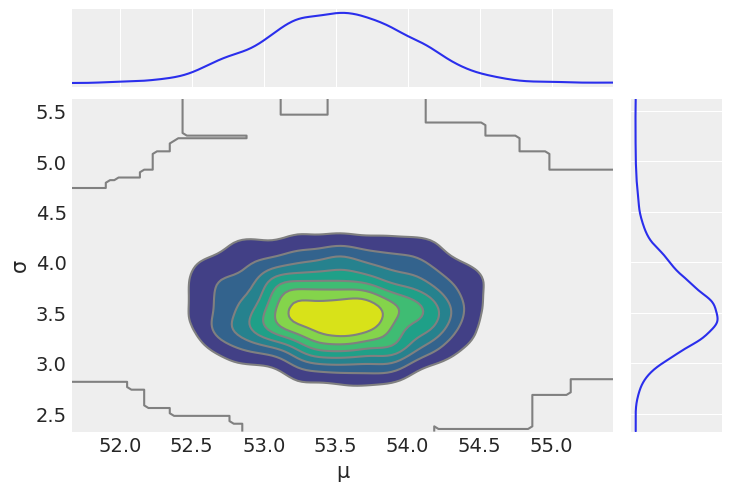

In [7]:
az.plot_pair(trace_g,kind="kde",marginals=True)